<a href="https://colab.research.google.com/github/chaos44/generative_deep_learning/blob/main/chap7/7_5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!git clone -b tensorflow_2 https://github.com/davidADSP/GDL_code.git

Cloning into 'GDL_code'...
remote: Enumerating objects: 391, done.
remote: Total 391 (delta 0), reused 0 (delta 0), pack-reused 391
Receiving objects: 100% (391/391), 22.13 MiB | 35.19 MiB/s, done.
Resolving deltas: 100% (237/237), done.


In [ ]:
cd GDL_code/

/content/GDL_code


In [ ]:
pip install --upgrade music21

     |████████████████████████████████| 19.2MB 165kB/s 
  Created wheel for music21: filename=music21-6.3.0-cp36-none-any.whl size=21888021 sha256=f4a2ededb2290ae7a2fdcceb81529c7690f0966a80aa3dc0672f295c6a69c391
  Stored in directory: /root/.cache/pip/wheels/02/e8/2c/eed32afec2b6c6f945a17280c4e4df1cf2e8cd15ebe1025680
Successfully built music21
  Found existing installation: music21 5.5.0
    Uninstalling music21-5.5.0:
      Successfully uninstalled music21-5.5.0


In [ ]:
from music21 import converter, chord, note

*7.4で生成したweightsフォルダー内の4つのweightsを、/GDL_code/run/compose/0017_chorales/weights/に入れてから実行してください

In [ ]:
import os
import matplotlib.pyplot as plt
import numpy as np

from music21 import midi
from music21 import note, stream, duration
from music21 import converter

from models.MuseGAN import MuseGAN

from utils.loaders import load_music

from keras.models import load_model

In [ ]:
# run params
SECTION = 'compose'
RUN_ID = '0017'
DATA_NAME = 'chorales'
FILENAME = 'Jsb16thSeparated.npz'
RUN_FOLDER = 'run/{}/'.format(SECTION)
RUN_FOLDER += '_'.join([RUN_ID, DATA_NAME])

### **data**

In [ ]:
BATCH_SIZE = 64
n_bars = 2
n_steps_per_bar = 16
n_pitches = 84
n_tracks = 4

data_binary, data_ints, raw_data = load_music(DATA_NAME, FILENAME, n_bars, n_steps_per_bar)
# data_binary = np.squeeze(data_binary)

In [ ]:
gan = MuseGAN(input_dim = data_binary.shape[1:]
        , critic_learning_rate = 0.001
        , generator_learning_rate = 0.001
        , optimiser = 'adam'
        , grad_weight = 10
        , z_dim = 32
        , batch_size = BATCH_SIZE
        , n_tracks = n_tracks
        , n_bars = n_bars
        , n_steps_per_bar = n_steps_per_bar
        , n_pitches = n_pitches
        )

In [ ]:
gan.load_weights(RUN_FOLDER, None)

In [ ]:
gan.generator.summary()

Model: "functional_55"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
melody_input (InputLayer)       [(None, 4, 32)]      0                                            
__________________________________________________________________________________________________
chords_input (InputLayer)       [(None, 32)]         0                                            
__________________________________________________________________________________________________
lambda_23 (Lambda)              (None, 32)           0           melody_input[0][0]               
__________________________________________________________________________________________________
lambda_24 (Lambda)              (None, 32)           0           melody_input[0][0]               
______________________________________________________________________________________

In [ ]:
gan.critic.summary()

Model: "functional_35"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
critic_input (InputLayer)    [(None, 2, 16, 84, 4)]    0         
_________________________________________________________________
conv3d_8 (Conv3D)            multiple                  1152      
_________________________________________________________________
leaky_re_lu_9 (LeakyReLU)    multiple                  0         
_________________________________________________________________
conv3d_9 (Conv3D)            multiple                  16512     
_________________________________________________________________
leaky_re_lu_10 (LeakyReLU)   multiple                  0         
_________________________________________________________________
conv3d_10 (Conv3D)           multiple                  196736    
_________________________________________________________________
leaky_re_lu_11 (LeakyReLU)   multiple                

### **view sample score**

In [ ]:
chords_noise = np.random.normal(0, 1, (1, gan.z_dim))
style_noise = np.random.normal(0, 1, (1, gan.z_dim))
melody_noise = np.random.normal(0, 1, (1, gan.n_tracks, gan.z_dim))
groove_noise = np.random.normal(0, 1, (1, gan.n_tracks, gan.z_dim))

In [ ]:
gen_scores = gan.generator.predict([chords_noise, style_noise, melody_noise, groove_noise])

In [ ]:
np.argmax(gen_scores[0,0,0:4,:,3], axis = 1)

array([50, 60, 50, 55])

In [ ]:
gen_scores[0,0,0:4,60,3] = 0.02347812

In [ ]:
filename = 'example'
gan.notes_to_midi(RUN_FOLDER, gen_scores, filename)
gen_score = converter.parse(os.path.join(RUN_FOLDER, 'samples/{}.midi'.format(filename)))
gen_score.show()

SubConverterException: ignored

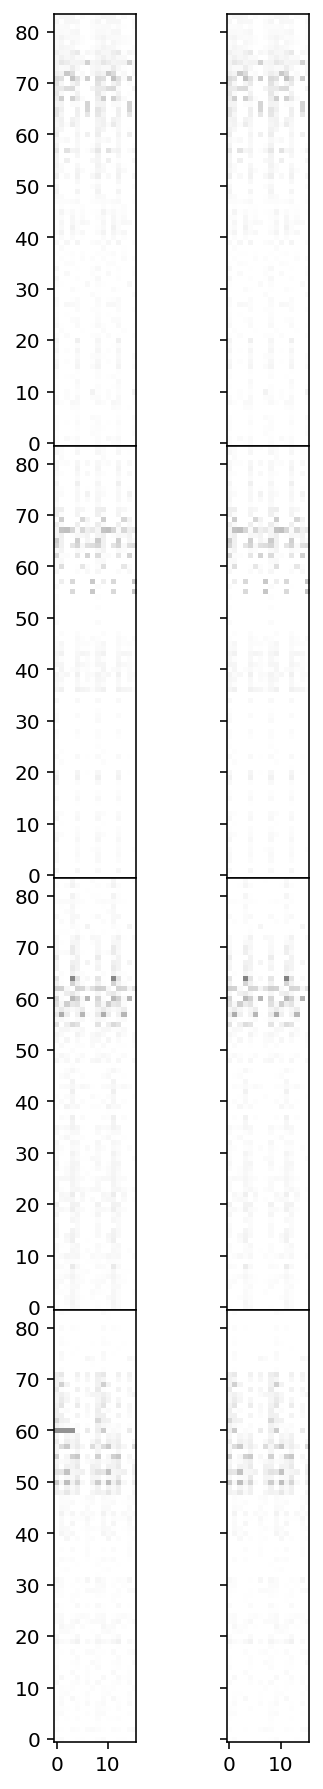

In [ ]:
gan.draw_score(gen_scores, 0)

## **find the closest match**


In [ ]:
def find_closest(data_binary, score):
    current_dist = 99999999
    current_i = -1
    for i, d in enumerate(data_binary):
        dist = np.sqrt(np.sum(pow((d - score),2)))
        if dist < current_dist:
            current_i = i
            current_dist = dist
        
    return current_i

In [ ]:
closest_idx = find_closest(data_binary, gen_scores[0])
closest_data = data_binary[[closest_idx]]
print(closest_idx)

3


In [ ]:
filename = 'closest'
gan.notes_to_midi(RUN_FOLDER, closest_data,filename)
closest_score = converter.parse(os.path.join(RUN_FOLDER, 'samples/{}.midi'.format(filename)))
print('original')
gen_score.show()
print('closest')
closest_score.show()

original


SubConverterException: ignored

## **changing the chords noise**

In [ ]:
chords_noise_2 = 5 * np.ones((1, gan.z_dim))

In [ ]:
chords_scores = gan.generator.predict([chords_noise_2, style_noise, melody_noise, groove_noise])

In [ ]:
filename = 'changing_chords'
gan.notes_to_midi(RUN_FOLDER, chords_scores, filename)
chords_score = converter.parse(os.path.join(RUN_FOLDER, 'samples/{}.midi'.format(filename)))
print('original')
gen_score.show()
print('chords noise changed')
chords_score.show()

original


SubConverterException: ignored

## **changing the chords noise**

In [ ]:
style_noise_2 = 5 * np.ones((1, gan.z_dim))

In [ ]:
style_scores = gan.generator.predict([chords_noise, style_noise_2, melody_noise, groove_noise])

In [ ]:
filename = 'changing_style'
gan.notes_to_midi(RUN_FOLDER, style_scores, filename)
style_score = converter.parse(os.path.join(RUN_FOLDER, 'samples/{}.midi'.format(filename)))
print('original')
gen_score.show()
print('style noise changed')
style_score.show()

original


SubConverterException: ignored

 ## **changing the melody noise**
 

In [ ]:
melody_noise_2 = np.copy(melody_noise)
melody_noise_2[0,0,:] = 5 * np.ones(gan.z_dim)

In [ ]:
melody_scores = gan.generator.predict([chords_noise, style_noise, melody_noise_2, groove_noise])

In [ ]:
filename = 'changing_melody'
gan.notes_to_midi(RUN_FOLDER, melody_scores, filename)
melody_score = converter.parse(os.path.join(RUN_FOLDER, 'samples/{}.midi'.format(filename)))
print('original')
gen_score.show()
print('melody noise changed')
melody_score.show()

original


SubConverterException: ignored

## **changing the groove noise**


In [ ]:
groove_noise_2 = np.copy(groove_noise)
groove_noise_2[0,3,:] = 5 * np.ones(gan.z_dim)

In [ ]:
groove_scores = gan.generator.predict([chords_noise, style_noise, melody_noise, groove_noise_2])

In [ ]:
filename = 'changing_groove'
gan.notes_to_midi(RUN_FOLDER, groove_scores, filename)
groove_score = converter.parse(os.path.join(RUN_FOLDER, 'samples/{}.midi'.format(filename)))
print('original')
gen_score.show()
print('groove noise changed')
groove_score.show()

original


SubConverterException: ignored